# Using Spectral Weights

This guide shows how to weight Scans and spectra during averaging and how to find out what weights were used in the process.


You can find a copy of this tutorial as a Jupyter notebook [here](https://github.com/GreenBankObservatory/dysh/blob/main/notebooks/examples/using_spectral_weights.ipynb) or download it by right clicking  <a href="https://raw.githubusercontent.com/GreenBankObservatory/dysh/refs/heads/main/notebooks/examples/using_spectral_weights.ipynb" download>here</a> and selecting "Save Link As".

## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for the data reduction.
from dysh.fits.gbtfitsload import GBTFITSLoad

# This module is used for custom plotting.
import matplotlib.pyplot as plt

# These modules are only used to download the data.
from pathlib import Path
from dysh.util.download import from_url
import numpy as np
import astropy.units as u
np.set_printoptions(precision=4, threshold=11, floatmode='fixed')

## Data Retrieval

Download the example SDFITS data, if necessary.

In [2]:
#url = "http://www.gb.nrao.edu/dysh/example_data/mixed-fs-ps/data/TGBT24B_613_04.raw.vegas.trim.fits"
#savepath = Path.cwd() / "data"
#savepath.mkdir(exist_ok=True) # Create the data directory if it does not exist.
#filename = from_url(url, savepath)

In [3]:
from dysh.util import get_project_testdata
filename = get_project_testdata() / "AGBT05B_047_01/AGBT05B_047_01.raw.acs"

## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [4]:
sdf = GBTFITSLoad(filename)
sdf.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


### Position Switched Calibration
We calibrate several scans at once for NGC5291.  This results in a ScanBlock with 4 scans, each with 11 integrations. The default weights are unity, with one weight value per integration.


In [5]:
pssb = sdf.getps(object='NGC5291',ifnum=0,plnum=1,fdnum=0)
print(f"Number of scans: {len(pssb)}, Number of integrations per scan: {[len(k) for k in pssb]}")
print(f"Scan weights: {pssb.weights}")

Number of scans: 4, Number of integrations per scan: [11, 11, 11, 11]
Scan weights: [array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
       1.0000, 1.0000, 1.0000]), array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
       1.0000, 1.0000, 1.0000]), array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
       1.0000, 1.0000, 1.0000]), array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
       1.0000, 1.0000, 1.0000])]


## Applying weights when averaging Scans
When averaging scans to create a final spectrum, you can choose from dysh's two options ('tsys' or None) or supply your own weight array.

### 1. System temperature weighting
The default for `timeaverage()` is 'tsys' which calculates and applies system temperature weighting to each integration: 

$w = t_{exp} \times \delta\nu/T_{sys}^2$,

where $t_{exp}$ is the integraton exposure time, $\delta\nu$ is the channel width, and $T_{sys}$ is the system temperature.  You can check what those weights will be with `tsys_weight`. 

In [6]:
pssb.tsys_weight

array([array([20.0224, 19.2378, 19.8947, 19.1375, 19.4362, 19.2499, 19.9478,
              19.8177, 19.9040, 19.8679, 19.1755])                          ,
       array([18.9448, 19.7844, 19.8543, 19.9005, 19.9597, 19.0888, 18.9758,
              18.5760, 19.7611, 19.7144, 19.7097])                          ,
       array([18.7716, 19.6226, 19.7020, 19.6861, 19.6588, 19.8566, 19.5728,
              19.6090, 18.7416, 18.6538, 18.7559])                          ,
       array([18.4426, 18.3684, 18.3461, 18.3960, 17.9534, 19.0497, 19.0977,
              19.1848, 19.0981, 19.0913, 18.3422])                          ],
      dtype=object)

(Note this is an array of arrays rather than a multidimensional array because different Scans may have differing numbers of integrations).

`timeaverage()` with the default arguments will use these weights.  The final spectral weight is the sum of all weights.

final weights=[847.9619254640448 847.9619254640448 847.9619254640448 ...
 847.9619254640448 847.9619254640448 847.9619254640448]


{'mean': <Quantity 0.0049 K>,
 'median': <Quantity 0.0035 K>,
 'rms': <Quantity 0.0593 K>,
 'min': <Quantity -1.7480 K>,
 'max': <Quantity 0.7666 K>,
 'npt': 32768,
 'nan': 0}

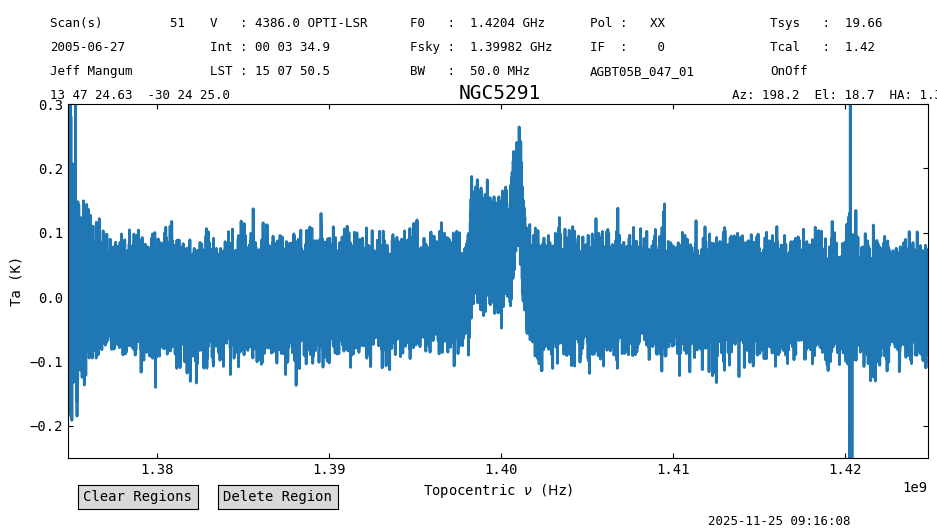

In [7]:
ta = pssb.timeaverage()  # default is weights='tsys'
exclude_regions=[(1.37*u.GHz,1.38*u.GHz),(1.395*u.GHz,1.405*u.GHz),(1.42*u.GHz,1.43*u.GHz)]
ta.baseline(degree=1, remove=True, exclude=exclude_regions)
ta.plot(ymin=-0.25,ymax=0.3)
print(f"final weights={ta.weights}")
ta.stats()

### 2. Equal weighting
Supplying `weights=None` will weight all integrations the same.  In this case, the result is not much different thatn `tsys`, because the $T_{sys}$ weights were already pretty uniform.

final weights=[4.0 4.0 4.0 ... 4.0 4.0 4.0]


{'mean': <Quantity 0.0049 K>,
 'median': <Quantity 0.0034 K>,
 'rms': <Quantity 0.0593 K>,
 'min': <Quantity -1.7494 K>,
 'max': <Quantity 0.7663 K>,
 'npt': 32768,
 'nan': 0}

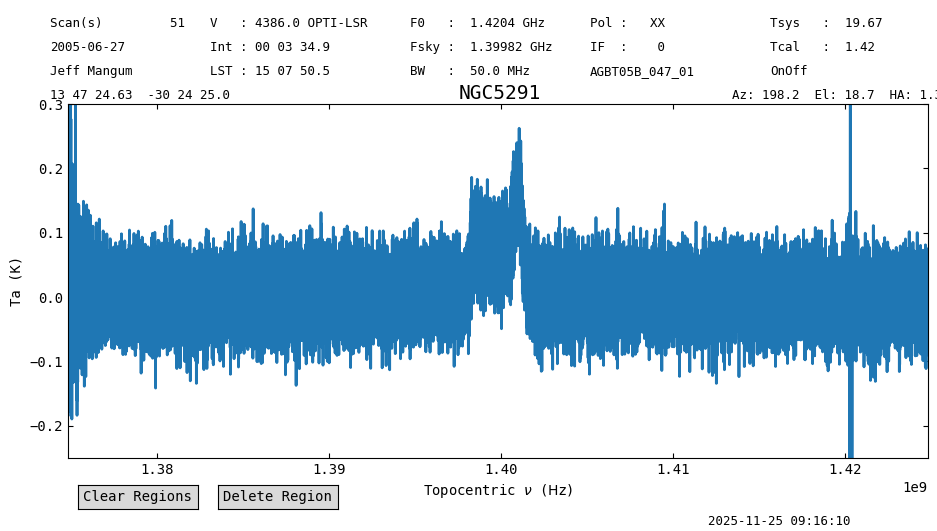

In [8]:
ta2 = pssb.timeaverage(weights=None)  
ta2.baseline(degree=1,remove=True,exclude=exclude_regions)
ta2.plot(ymin=-0.25,ymax=0.3)
print(f"final weights={ta2.weights}")
ta2.stats()

### 3. User-supplied weights
You can supply a numpy array of weights to apply.  For `ScanBlock.timeavearage()` the weights must have shape `(Nint,)` or `(Nint,nchan)` where `Nint` is the number of integrations in the ScanBlock and `nchan` is the number of channels in each Scan.  

#### 3a.  Number of weights equal to number of integrations.
We create a slightly silly example, that weights later integrations more.

final weights=[990.0 990.0 990.0 ... 990.0 990.0 990.0]


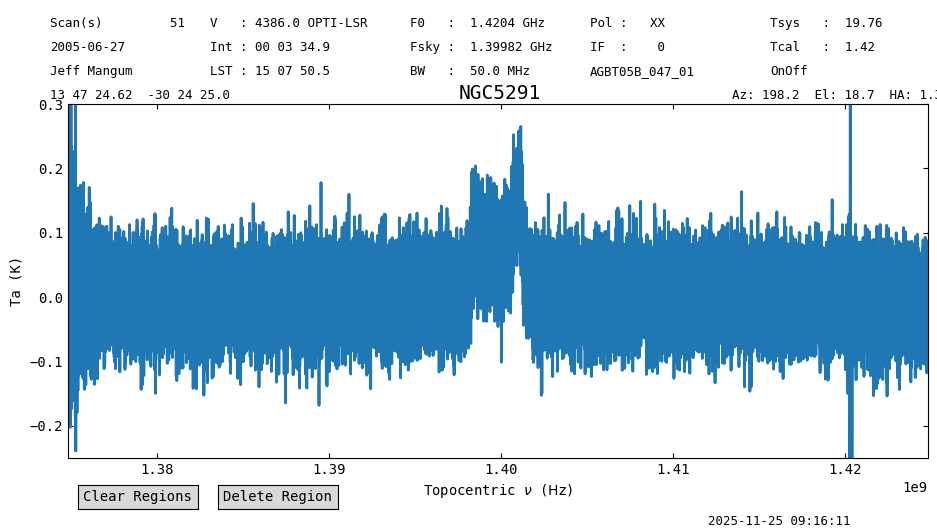

In [9]:
w = np.arange(1,pssb.nint+1,dtype=float)
ta3 = pssb.timeaverage(weights=w)
ta3.baseline(degree=1,remove=True,exclude=exclude_regions)
ta3.plot(ymin=-0.25,ymax=0.3)
print(f"final weights={ta3.weights}")

#### 3b.  Weights array with shape `(nint,nchan)`
Supposed you had a channel-based $T_{sys}$ for each integration and wanted to calculate and apply system temperature weights. This can be accomplished by giving a weights array to `ScanBlock.timeaverage()`.

First we fake a `tsys` array of the correct shape.  Then we calculate system temperate weights using the mean exposure time and mean channel width of the Scans.

In [10]:
from dysh.spectra import tsys_weight
tsys=30+np.random.rand(pssb.nint,pssb.nchan)*15.0  # a fake system temperature array in the 30-45K range
dt = np.mean(np.mean(pssb.exposure))
df = np.mean(np.mean(pssb.delta_freq))
w=tsys_weight(dt,df,tsys)
print(f"{tsys=}")
print(f"Weights array shape: {w.shape}")

tsys=array([[35.7377, 33.9328, 35.3016, ..., 38.4297, 31.4925, 33.0459],
       [38.7680, 38.3364, 33.4519, ..., 44.9299, 41.8005, 42.4635],
       [37.1374, 37.3327, 32.9857, ..., 43.5676, 42.6843, 31.3943],
       ...,
       [36.1366, 38.0932, 39.6652, ..., 43.3659, 41.7779, 38.6641],
       [42.8777, 42.5333, 37.7320, ..., 44.2919, 34.8921, 32.3081],
       [36.3122, 36.0609, 35.9376, ..., 38.9473, 40.8208, 43.8304]])
Weights array shape: (44, 32768)


final weights=[223.97538282382942 239.53217100524373 239.31217685335258 ...
 229.38523497407573 260.10288014224307 234.7949056715879]


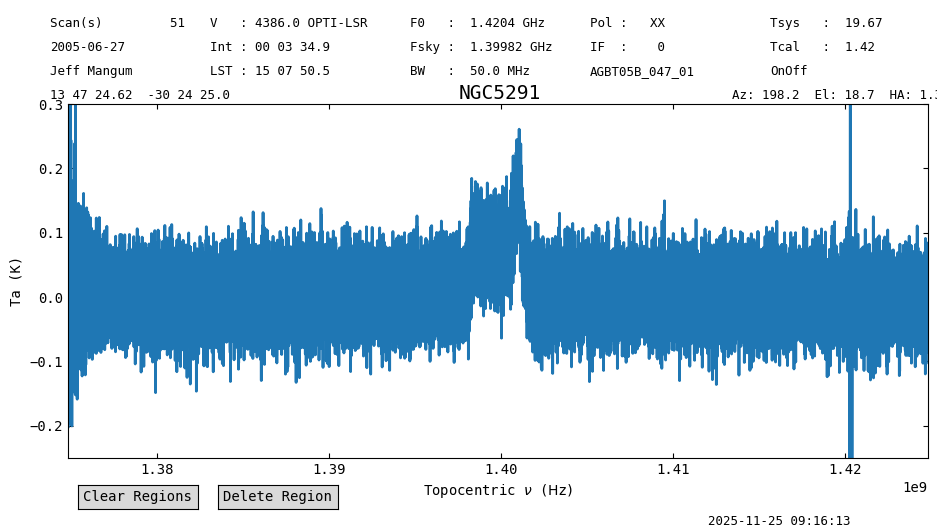

In [11]:
ta4 = pssb.timeaverage(weights=w)
ta4.baseline(degree=1,remove=True,exclude=exclude_regions)
ta4.plot(ymin=-0.25,ymax=0.3)
print(f"final weights={ta4.weights}")

### 4. Averaging lists of spectra with pre-computed weights
The method `average_spectra` can compute weighted averages in 3 ways.  The first two are the usual `weights='tsys'` and `weights=None` options.  The third option, `weights='spectral'` will average the spectra using the values in each of their `weights` array. 

In [12]:
from dysh.spectra import average_spectra 
sp = average_spectra([ta,ta2,ta3,ta3],weights='spectral')

final weights=[2831.9619254640447 2831.9619254640447 2831.9619254640447 ...
 2831.9619254640447 2831.9619254640447 2831.9619254640447]


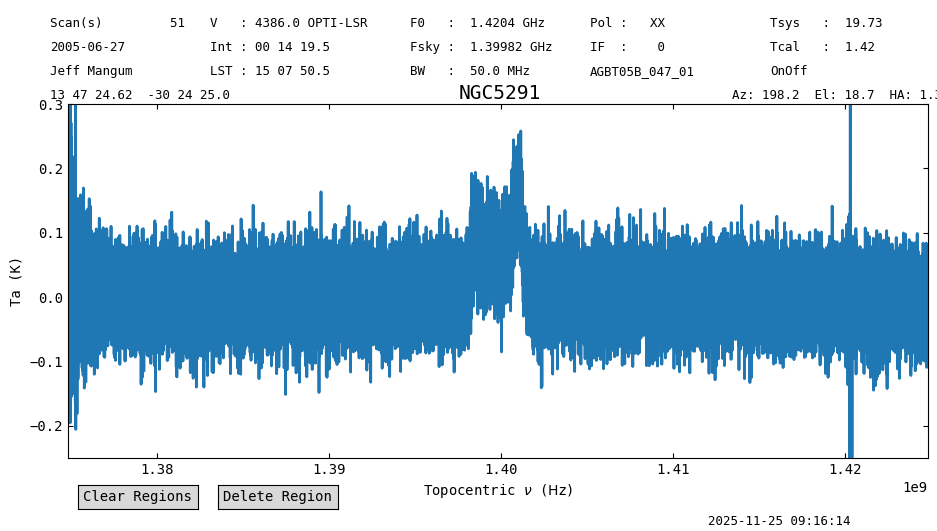

In [13]:
sp.plot(ymin=-0.25,ymax=0.3)
print(f"final weights={sp.weights}")